### Load data into data frames

In [137]:
import gzip
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import defaultdict
from itertools import groupby
import seaborn as sns

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)


def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

### Prepare text data for sentimental analysis

E.g.
Given fn.json with rating from 1 to 3,
generate fn_1.txt, fn_2.txt, fn_3.txt

In [138]:
def clean_text(text):
    return text.replace('\n', '')


def extract_review_text(path):
    df = getDF(path)
    dir = path.strip('.json.gz')

    # [1.0, 2.0, 3.0, 4.0, 5.0]
    rating_vals = set(df['overall'].tolist())
    print('Ratings are: {}'.format(rating_vals))

    fps = {r: open('%s_%s.txt'%(dir,str(r)), 'w') for r in rating_vals}
    for r in rating_vals:
      reviews = set(df[df['overall']==r]['reviewText'].values) #TODO: why duplicates?
      print('Extracting reviews for rating {}'.format(r))
      for review in reviews:
        fps[r].write(clean_text(review) + '\n')

    for r in fps:
      fps[r].close()
    
    print('Finish extracting reviews!')

In [139]:
path = 'data/Digital_Music_5.json.gz'
df = getDF(path)

In [140]:
df.shape

(169781, 12)

In [141]:
df[:3]

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,3,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,{'Format:': ' Audio CD'},Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,1370217600,NaN
1,5.0,NaN,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,{'Format:': ' Audio CD'},Ad,bien,Five Stars,1412985600,NaN
2,5.0,NaN,True,"02 11, 2014",A2VAMODP8M77NG,3426958910,{'Format:': ' Audio CD'},JTGabq,It was great to hear the old stuff again and I...,SLAYER!!!!!!!!!!!!!!!!!!!!!,1392076800,NaN


At the moment, we aren't using **'image'** and **'style'**

In [142]:
df = df.drop('image', 1)
df['vote'].fillna(0, inplace=True)

In [143]:
uniDf = df.drop('style', 1).drop_duplicates()
uniDf.shape

(146149, 10)

In [144]:
uniDf.drop_duplicates(subset=['reviewerID', 'asin']).shape

(145292, 10)

In [145]:
uniDf['vote'] = uniDf['vote'].apply(lambda v : str(v).replace(',', ''))
uniDf['vote'] = pd.to_numeric(uniDf['vote'])
uniDf['reviewText'].fillna('', inplace=True)

In [146]:
uniDf.reset_index(drop=True)
uniDf = uniDf[uniDf['reviewText'].apply(lambda x: len(x) <= 1000)]

In [147]:
ratings = list(uniDf['overall'])
votes = list(uniDf['vote'])
items = list(uniDf['asin'])
verified = list(uniDf['verified'])
reviews = list(uniDf['reviewText'])

count_r = [0] * 6
count_verified = [0] * 6
count_non_verified = [0] * 6
r_items = defaultdict(list)
count_r_items = [0] * 6
count_review_length = [0] * 7

In [148]:
item_rating = []
for i in range(len(ratings)):
    r_items[items[i]].append(ratings[i])
for item in r_items:
    counts = np.bincount(r_items[item])
    count = np.argmax(counts)
    count_r_items[count] += 1
count_r_items = count_r_items[1:]

In [149]:
zero_votes = []
non_zero_votes = []
verified_rating = []
non_verified_rating = []
review_length = []

for i in range(len(ratings)):
    if verified[i] == True:
        count_verified[int(ratings[i])] += 1
        verified_rating.append(ratings[i])
    else :
        count_non_verified[int(ratings[i])] += 1
        non_verified_rating.append(ratings[i])
    count_r[int(ratings[i])] += 1
    review_length.append(len(str(reviews[i])))

In [150]:
max_len = 0
for review in reviews:
    if type(review) == float:
        print(review)
    if len(review) > max_len:
        max_len = len(review)
max_len = max_len/7

In [151]:
i = 0
for k, g in groupby(sorted(review_length), key=lambda x: x//max_len):
    count_review_length[i] = len(list(g))
    i += 1
print(count_review_length)

[109310, 20348, 5382, 2500, 1569, 1340, 990]


In [152]:
print(count_r)
print(count_verified)
print(count_non_verified)
#print(review_length)

[0, 1801, 1482, 5582, 18750, 113824]
[0, 1158, 948, 4753, 16791, 103697]
[0, 643, 534, 829, 1959, 10127]


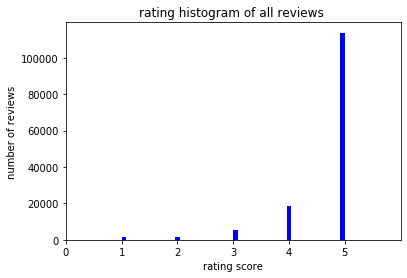

In [153]:
n,bins,patches = plt.hist(ratings,50, facecolor='blue')
plt.xlim([0,6])
plt.xlabel("rating score")
plt.ylabel("number of reviews")
plt.title("rating histogram of all reviews ")
plt.xticks(np.arange(0,6,1))
plt.savefig('rating_histogram')
plt.show()

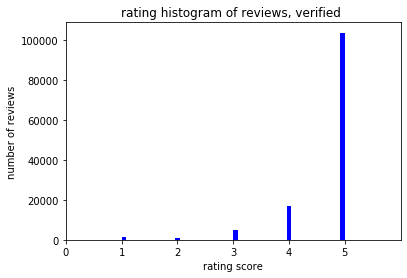

In [154]:
n,bins,patches = plt.hist(verified_rating,50, facecolor='blue')
plt.xlim([0,6])
plt.xlabel("rating score")
plt.ylabel("number of reviews")
plt.title("rating histogram of reviews, verified ")
plt.xticks(np.arange(0,6,1))
plt.savefig('verified_rating_histogram')
plt.show()

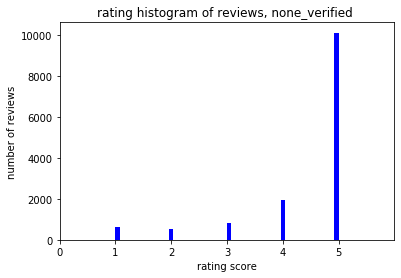

In [155]:
n,bins,patches = plt.hist(non_verified_rating,50, facecolor='blue')
plt.xlim([0,6])
plt.xlabel("rating score")
plt.ylabel("number of reviews")
plt.title("rating histogram of reviews, none_verified ")
plt.xticks(np.arange(0,6,1))
plt.savefig('none_verified rating_histogram')
plt.show()

Text(0.5, 1.0, 'rating percentage of items')

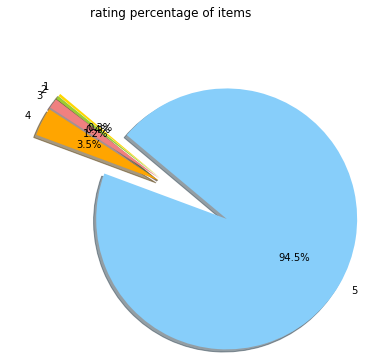

In [170]:
labels = ['1', '2', '3','4','5']
colors = ['gold', 'yellowgreen', 'lightcoral', 'orange','lightskyblue']
explode = (0.1, 0.1, 0.1, 0.1, 0.5)  # explode 1st slice


fig = plt.figure(figsize=[6, 6])
ax = fig.add_subplot(111)
ax.pie(count_r_items, labels=labels,explode = explode, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
ax.set_title("rating percentage of items")

Text(0.5, 1.0, 'review length')

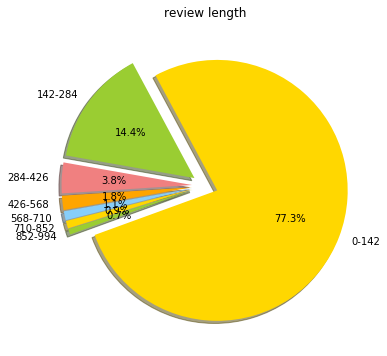

In [169]:
max_len = int(max_len)
labels = ['0-'+str(max_len), str(max_len)+'-'+str(max_len*2), str(max_len*2)+'-'+str(max_len*3),str(max_len*3)+'-'+str(max_len*4),str(max_len*4)+'-'+str(max_len*5), str(max_len*5)+'-'+str(max_len*6), str(max_len*6)+'-'+str(max_len*7)]
colors = ['gold', 'yellowgreen', 'lightcoral', 'orange','lightskyblue']
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)  # explode 1st slice

fig = plt.figure(figsize=[6, 6])
ax = fig.add_subplot(111)
ax.pie(count_review_length, labels=labels,explode = explode, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=200)
ax.set_title("review length")

### Vote distribution versus rating

In [113]:
uniDf.dtypes

overall           float64
vote                int64
verified             bool
reviewTime         object
reviewerID         object
asin               object
reviewerName       object
reviewText         object
summary            object
unixReviewTime      int64
dtype: object

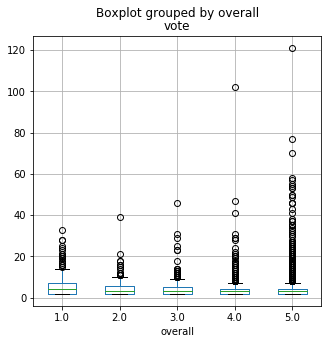

In [114]:
fig, ax = plt.subplots(figsize=(5,5))
plt.suptitle('')
uniDf[uniDf['vote'] != 0].boxplot(column=['vote'], by='overall', ax=ax)

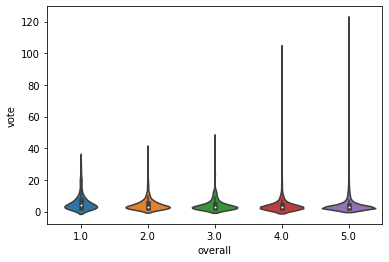

In [115]:
sns.violinplot(data=uniDf[uniDf['vote'] != 0], x='overall', y='vote')

### Extract and save each review and its rating

In [116]:
uniDf.to_csv(path.strip('.json.gz') + '.csv', columns = ['reviewerID', 'asin', 'overall'], index=False)

### Get a list of styles and save to JSON

In [117]:
styles = defaultdict(set)
for style in df['style'].values:
    if type(style) != dict:
        continue
    for key in style:
        styles[key.replace(':', '')].add(style[key])

In [118]:
with open(path.strip('.json.gz')+'_styles.json', 'w') as fp:
    data = {key:list(styles[key]) for key in styles}
    json.dump(data, fp, sort_keys=True, indent=4)

### Temporal Effects

Trend of number of reviews and average ratings over months

In [119]:
minMonth = uniDf['unixReviewTime'].min()//(30*24*60*60)

def unixTimeToMonth(row):
    return row['unixReviewTime']//(30*24*60*60) - minMonth

uniDf['normalizedMonth'] = uniDf.apply(unixTimeToMonth, axis=1)

print('Range of normalized months: {0} - {1}'.format(uniDf['normalizedMonth'].min(), uniDf['normalizedMonth'].max()))

Range of normalized months: 0 - 246


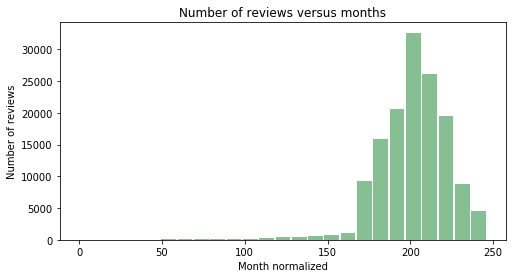

In [120]:
ax = uniDf.hist('normalizedMonth', bins=25, grid=False, figsize=(8,4), color='#86bf91', zorder=2, rwidth=0.9)
for x in ax[0]:
    x.set_title('Number of reviews versus months')
    x.set_xlabel('Month normalized')
    x.set_ylabel('Number of reviews')

Text(0.5, 1.0, 'Average rating versus months')

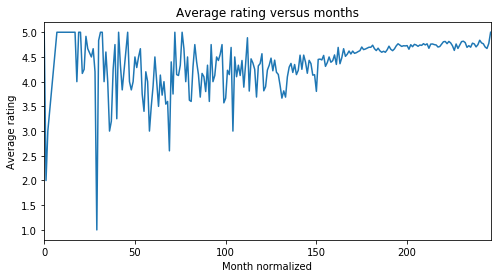

In [121]:
avgRatings = uniDf.groupby('normalizedMonth').mean()['overall']
ax = avgRatings.plot(figsize=(8,4))
ax.set_ylabel('Average rating')
ax.set_xlabel('Month normalized')
ax.set_title('Average rating versus months')